In [1]:
import os
os.environ["CUDA_VIVIBLE_DEVICES"]='1'

In [2]:

import torch
import matplotlib.pyplot as plt
import config as CFG
from models import ST_GCHB
from dataset import ST_GCHB_Dataset
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn import neighbors
import torch.utils.data.distributed
import scipy.sparse

#print the current scanpy version
print(sc.__version__)
epoch=CFG.epochs
print(epoch)
print(CFG.topk)
print(torch.cuda.current_device())

/home/zjj/anaconda3/envs/ccx_rp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.9.3
4
10
0


In [3]:

def visualize_umap_clusters(expr_matrix, preprocess = True, normalize_and_log = True, batch_idx = None, n_neighbors=150, n_top_genes=1024, max_value=10, legend_loc='on data', show=False, save=False, save_name='umap_clusters.png'):
    #! scanpy input matrix has cells as rows and genes as columns, same as this function
    if preprocess:
        # # Filter out genes with expression in less than 50 spots (for a ~8000 spot dataset over 4 slices)
        # expressed = np.sum(expr_matrix>0, axis=0)
        # expr_matrix = expr_matrix[:,expressed>50]

        # Create AnnData object with batch index as an observation
        adata = sc.AnnData(X=expr_matrix, dtype=expr_matrix.dtype)
        if batch_idx is not None: 
            adata.obs['batch_idx'] = batch_idx

        # Preprocess the data
        if normalize_and_log:
            sc.pp.normalize_total(adata)
            sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
        print("n_top_genes: ", adata.var['highly_variable'].sum())
        # sc.pp.scale(adata, max_value=max_value)
    else: # false
        adata = sc.AnnData(X=expr_matrix, dtype=expr_matrix.dtype)
        if batch_idx is not None:
            adata.obs['batch_idx'] = batch_idx

    # Run UMAP and clustering on the preprocessed data
    # sc.pp.scale(adata, max_value=max_value)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=preprocess)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=50)
    
    sc.tl.umap(adata)
    print("Running Leiden clustering")
    sc.tl.leiden(adata)
    print("n_clusters: ", adata.obs['leiden'].nunique())
    print("Plotting UMAP clusters")

    # Plot the UMAP embedding with cell clusters and batch index
    if batch_idx is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        sc.pl.umap(adata, color='leiden', ax=ax, show=show, legend_loc=legend_loc)

        # Save the figure
        if save:
            fig.savefig(save_name, dpi=300, bbox_inches='tight')

        return adata

    else:
        fig, axs = plt.subplots(ncols=2, figsize=(10,5))

        # Plot the UMAP embedding with cell clusters
        sc.pl.umap(adata, color='leiden', ax=axs[0], show=False, legend_loc=legend_loc)

        # Plot the UMAP embedding with batch information
        sc.pl.umap(adata, color='batch_idx', ax=axs[1], show=False, legend_loc=legend_loc)


        # Save the figure
        if save:
            fig.savefig(save_name, dpi=300, bbox_inches='tight')

        return adata

def Cal_Spatial_Net(dataset, rad=CFG.radius, k=CFG.topk):  
    X = torch.Tensor()  # tensor([])
    for idx in range(len(dataset)):
        if idx == 0:
            X = np.append(X, dataset[idx]['spatial_coords'])  # tensor([a,b])
            X = torch.from_numpy(X)  # from array to tensor
            X = X.unsqueeze(0)  # shape:[[a,b]]
        else:
            coor = [dataset[idx]['spatial_coords']]
            X = np.append(X, coor, axis=0)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k + 1).fit(X)
    distances, indices = nbrs.kneighbors(X)
    KNN_list = []
    for it in range(indices.shape[0]):
        KNN_list.append(pd.DataFrame(zip([it] * indices.shape[1], indices[it, :], distances[it, :])))
    # print(KNN_list)
    adj = np.zeros((indices.shape[0], indices.shape[0]))
    KNN_list = np.array(KNN_list)
    for idx in range(len(KNN_list)):
        t = KNN_list[idx, :]  
        for p in range(len(t)):  
            if t[p,2]<rad:
                x = int(t[p, 0])
                y = int(t[p, 1])
                adj[x, y] = 1
    return adj

def build_loaders_inference():
    print("Building loaders")
    print("topk:",CFG.topk)

    # load all of your slices as follow:
    dataset1 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_1.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/1/harmony1.npy",
                barcode_path = "./data/filtered_expression_matrices/1/barcodes1.tsv")
    dataset2 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_2.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/2/harmony2.npy",
                barcode_path = "./data/filtered_expression_matrices/2/barcodes2.tsv")
    dataset3 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_3.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/3/harmony3.npy",
                barcode_path = "./data/filtered_expression_matrices/3/barcodes3.tsv")
    dataset4 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_4.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/4/harmony4.npy",
                barcode_path = "./data/filtered_expression_matrices/4/barcodes4.tsv")
    dataset5 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_5.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/5/harmony5.npy",
                barcode_path = "./data/filtered_expression_matrices/5/barcodes5.tsv")
    dataset6 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_6.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/6/harmony6.npy",
                barcode_path = "./data/filtered_expression_matrices/6/barcodes6.tsv")
    dataset7 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_7.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/7/harmony7.npy",
                barcode_path = "./data/filtered_expression_matrices/7/barcodes7.tsv")
    dataset8 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_8.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/8/harmony8.npy",
                barcode_path = "./data/filtered_expression_matrices/8/barcodes8.tsv")
    dataset9 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_9.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/9/harmony9.npy",
                barcode_path = "./data/filtered_expression_matrices/9/barcodes9.tsv")
    dataset10 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_10.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/10/harmony10.npy",
                barcode_path = "./data/filtered_expression_matrices/10/barcodes10.tsv")
    dataset11 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_11.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/11/harmony11.npy",
                barcode_path = "./data/filtered_expression_matrices/11/barcodes11.tsv")
    dataset12 = ST_GCHB_Dataset(
                spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_12.csv",
                reduced_mtx_path = "./data/filtered_expression_matrices/12/harmony12.npy",
                barcode_path = "./data/filtered_expression_matrices/12/barcodes12.tsv")

    
    adj1 = Cal_Spatial_Net(dataset1, CFG.radius, CFG.topk)
    adj2 = Cal_Spatial_Net(dataset2, CFG.radius, CFG.topk)
    adj3 = Cal_Spatial_Net(dataset3, CFG.radius, CFG.topk)
    adj4 = Cal_Spatial_Net(dataset4, CFG.radius, CFG.topk)
    adj5 = Cal_Spatial_Net(dataset5, CFG.radius, CFG.topk)
    adj6 = Cal_Spatial_Net(dataset6, CFG.radius, CFG.topk)
    adj7 = Cal_Spatial_Net(dataset7, CFG.radius, CFG.topk)
    adj8 = Cal_Spatial_Net(dataset8, CFG.radius, CFG.topk)
    adj9 = Cal_Spatial_Net(dataset9, CFG.radius, CFG.topk)
    adj10 = Cal_Spatial_Net(dataset10, CFG.radius, CFG.topk)
    adj11 = Cal_Spatial_Net(dataset11, CFG.radius, CFG.topk)
    adj12 = Cal_Spatial_Net(dataset12, CFG.radius, CFG.topk)
    adj1 = scipy.sparse.coo_matrix(adj1)
    adj2 = scipy.sparse.coo_matrix(adj2)
    adj3 = scipy.sparse.coo_matrix(adj3)
    adj4 = scipy.sparse.coo_matrix(adj4)
    adj5 = scipy.sparse.coo_matrix(adj5)
    adj6 = scipy.sparse.coo_matrix(adj6)
    adj7 = scipy.sparse.coo_matrix(adj7)
    adj8 = scipy.sparse.coo_matrix(adj8)
    adj9 = scipy.sparse.coo_matrix(adj9)
    adj10 = scipy.sparse.coo_matrix(adj10)
    adj11 = scipy.sparse.coo_matrix(adj11)
    adj12 = scipy.sparse.coo_matrix(adj12)
    
    print("Finished building loaders")
    return (dataset1,dataset2,dataset3,dataset4,dataset5,dataset6,dataset7,dataset8,dataset9,dataset10,dataset11,dataset12,
            adj1,adj2,adj3,adj4,adj5,adj6,adj7,adj8,adj9,adj10,adj11,adj12)

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def get_image_embeddings(model): # your testing slice
    dataset = ST_GCHB_Dataset(
            spatial_pos_path = "./data/tissue_pos_matrices/tissue_positions_list_X.csv",
            reduced_mtx_path = "./data/filtered_expression_matrices/X/harmonyX.npy",
            barcode_path = "./data/filtered_expression_matrices/X/barcodesX.tsv")
    adj = Cal_Spatial_Net(dataset, CFG.radius, CFG.topk)
    adj = scipy.sparse.coo_matrix(adj)
    sp_Adj = sparse_mx_to_torch_sparse_tensor(adj).cuda()
    graph_batch=torch.load("data/graph_batch_X.pt").cuda()
    with torch.no_grad():
        features=model.image_encoder(graph_batch)
        features=model.image_dgi_model.model.embed(features,sp_Adj,1,None)
        image_embeddings=model.image_projection(features)
    return image_embeddings
        

dataset=torch.load('pca_res.pt')

def get_spot_embeddings( model):
    #only traing slices
    _,_,_,_,_,_,_,_,_,_,_,_,adj1,adj2,adj3,adj4,adj5,adj6,adj7,adj8,adj9,adj10,_,_ = build_loaders_inference()
    
    sp_Adj1 = sparse_mx_to_torch_sparse_tensor(adj1)
    sp_Adj2 = sparse_mx_to_torch_sparse_tensor(adj2)
    sp_Adj3 = sparse_mx_to_torch_sparse_tensor(adj3)
    sp_Adj4 = sparse_mx_to_torch_sparse_tensor(adj4)
    sp_Adj5 = sparse_mx_to_torch_sparse_tensor(adj5)
    sp_Adj6 = sparse_mx_to_torch_sparse_tensor(adj6)
    sp_Adj7 = sparse_mx_to_torch_sparse_tensor(adj7)
    sp_Adj8 = sparse_mx_to_torch_sparse_tensor(adj8)
    sp_Adj9 = sparse_mx_to_torch_sparse_tensor(adj9)
    sp_Adj10 = sparse_mx_to_torch_sparse_tensor(adj10)
    List=list([adj1.shape[0],adj2.shape[0],adj3.shape[0],adj4.shape[0],adj5.shape[0],adj6.shape[0],adj7.shape[0],
               adj8.shape[0],adj9.shape[0],adj10.shape[0]])
    t=0
    for i in range(len(List)):
        if i==0:
            dataset1=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==1:
            dataset2=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==2:
            dataset3=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==3:
            dataset4=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==4:
            dataset5=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==5:
            dataset6=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==6:
            dataset7=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==7:
            dataset8=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==8:
            dataset9=dataset[t:t+List[i],:]
            t+=List[i]
        elif i==9:
            dataset10=dataset[t:t+List[i],:]
            t+=List[i]
    with torch.no_grad():
        for epoch in range(10):  
            if epoch == 0:
                adj = sp_Adj1
                train_loader=dataset1
            elif epoch == 1:
                adj = sp_Adj2
                train_loader=dataset2
            elif epoch==2:
                adj = sp_Adj3
                train_loader=dataset3
            elif epoch==3:
                adj = sp_Adj4
                train_loader=dataset4
            elif epoch==4:
                adj = sp_Adj5
                train_loader=dataset5
            elif epoch==5:
                adj = sp_Adj6
                train_loader=dataset6
            elif epoch==6:
                adj = sp_Adj7
                train_loader=dataset7
            elif epoch==7:
                adj = sp_Adj8
                train_loader=dataset8
            elif epoch==8:
                adj = sp_Adj9
                train_loader=dataset9
            elif epoch==9:
                adj = sp_Adj10
                train_loader=dataset10
            torch.cuda.empty_cache()
            gene_fts=train_loader.cuda()
            gene_fts = gene_fts.unsqueeze(0)
            adj=adj.cuda()
            feature = model.spot_dgi_model.model.embed(gene_fts, adj, 1,None)
            feature=model.spot_projection(feature)
            print("spot_feature:",feature.shape)
            if epoch == 0:
                features_1=feature
            elif epoch == 1:
                features_2=feature
            elif epoch == 2:
                features_3=feature
            elif epoch == 3:
                features_4=feature
            elif epoch==4:
                features_5=feature
            elif epoch==5:
                features_6=feature
            elif epoch==6:
                features_7=feature
            elif epoch==7:
                features_8=feature
            elif epoch==8:
                features_9=feature
            elif epoch==9:
                features_10=feature
            torch.cuda.empty_cache()
    return features_1, features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,features_10
   
def find_matches(spot_embeddings, query_embeddings, top_k=50):
    #find the closest matches
    spot_embeddings = torch.tensor(spot_embeddings)
    query_embeddings = torch.tensor(query_embeddings)
    # query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)
    # spot_embeddings = F.normalize(spot_embeddings, p=2, dim=-1)
    dot_similarity = query_embeddings @ spot_embeddings.T   
    print(dot_similarity.shape)
    _, indices = torch.topk(dot_similarity.squeeze(0), k=top_k)


    return indices.cpu().numpy()

In [4]:
print(torch.cuda.current_device())
ST_GCHB_model_path = "./ST_GCHB.pt"

save_path = "./embeddings/"
model=ST_GCHB().cuda()
model.load_state_dict(torch.load(ST_GCHB_model_path))
model.eval()
print("finshed loading ST-GCHB")

with torch.no_grad():
    image_embeddings_test=get_image_embeddings(model) 
    spt_emb_1,spt_emb_2,spt_emb_3,spt_emb_4,spt_emb_5,spt_emb_6,spt_emb_7,spt_emb_8,spt_emb_9,spt_emb_10=get_spot_embeddings(model)

print(image_embeddings_test.shape)


0


/home/zjj/anaconda3/envs/ccx_rp/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zjj/anaconda3/envs/ccx_rp/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Image encoder is ResNet50
finshed loading ST-GCHB
Finished loading all files
Building loaders
topk: 10
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished loading all files
Finished building loaders
spot_feature: torch.Size([1, 3661, 128])
spot_feature: torch.Size([1, 3498, 128])
spot_feature: torch.Size([1, 4110, 128])
spot_feature: torch.Size([1, 4015, 128])
spot_feature: torch.Size([1, 3639, 128])
spot_feature: torch.Size([1, 3673, 128])
spot_feature: torch.Size([1, 3592, 128])
torch.Size([1, 3460, 128])


In [5]:

Spot_embeddings_all = np.array(torch.concatenate([spt_emb_1, spt_emb_2, spt_emb_3,spt_emb_4,spt_emb_5,spt_emb_6,spt_emb_7,spt_emb_8
                                                  ,spt_emb_9,spt_emb_10], axis = 1).cpu())
image_query = np.array(image_embeddings_test.squeeze().cpu())
spot_embeddings_all = Spot_embeddings_all.squeeze(0)
print("image_feature: ",image_query.shape)
print("spot_feature_dataset: ",spot_embeddings_all.shape)
print(CFG.topk)


image_feature:  (3460, 128)
spot_feature_dataset:  (26188, 128)
10


In [6]:
# test training set slice 
spot_expression1 = np.load("data/filtered_expression_matrices/1/harmony1.npy")
spot_expression2 = np.load("data/filtered_expression_matrices/2/harmony2.npy")
spot_expression3 = np.load("data/filtered_expression_matrices/3/harmony3.npy")
spot_expression4 = np.load("data/filtered_expression_matrices/4/harmony4.npy")
spot_expression5 = np.load("data/filtered_expression_matrices/5/harmony5.npy")
spot_expression6 = np.load("data/filtered_expression_matrices/6/harmony6.npy")
spot_expression7 = np.load("data/filtered_expression_matrices/7/harmony7.npy")
spot_expression8 = np.load("data/filtered_expression_matrices/8/harmony8.npy")
spot_expression9 = np.load("data/filtered_expression_matrices/5/harmony9.npy")
spot_expression10 = np.load("data/filtered_expression_matrices/6/harmony10.npy")
spot_expression11 = np.load("data/filtered_expression_matrices/7/harmony11.npy")
spot_expression12 = np.load("data/filtered_expression_matrices/8/harmony12.npy")
spot_key = spot_embeddings_all
expression_key = np.concatenate([spot_expression1, spot_expression2,spot_expression3,spot_expression4,spot_expression5,spot_expression6,
                                 spot_expression7,spot_expression8,spot_expression9,spot_expression10], axis = 1).T

In [16]:

#query
expression_gt = spot_expression8

method = "average"
save_path = ""
print("expression_key shape: ", expression_key.shape)



if method == "average":
    print("finding matches, using average of top 50 expressions")
    indices = find_matches(spot_key, image_query, top_k=50)
    matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
    matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
    for i in range(indices.shape[0]):
        matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0)
        matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0)

    print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
    print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)


true = expression_gt
pred = matched_spot_expression_pred.T

print("pred shape:",pred.shape)
print("true shape:",true.shape)


#genewise correlation
corr = np.zeros(pred.shape[1])
for i in range(pred.shape[1]):
    corr[i] = np.corrcoef(pred[:,i], true[:,i])[0,1] #corrcoef returns a matrix
#remove nan
corr = corr[~np.isnan(corr)]
print("Mean correlation acroalignment uniformityss cells: ", np.mean(corr))

true = expression_gt.T
pred = matched_spot_expression_pred
corr = np.zeros(pred.shape[1])
for i in range(pred.shape[1]):
    corr[i] = np.corrcoef(pred[:,i], true[:,i],)[0,1] #corrcoef returns a matrix
#remove nan
corr = corr[~np.isnan(corr)]
print("number of non-zero genes: ", corr.shape[0])
print("mean correlation: ", np.mean(corr))
print("max correlation: ", np.max(corr))
print("number of genes with correlation > 0.3: ", np.sum(corr > 0.3))

if save_path != "":
    np.save(save_path + "matched_spot_embeddings_pred.npy", matched_spot_embeddings_pred.T)
    np.save(save_path + "matched_spot_expression_pred.npy", matched_spot_expression_pred.T)



print(type(pred))
np.save('ST-GCHB.npy',pred)

expression_key shape:  (26188, 2000)
finding matches, using average of top 50 expressions
torch.Size([3460, 26188])
matched spot embeddings pred shape:  (3460, 128)
matched spot expression pred shape:  (3460, 2000)
pred shape: (2000, 3460)
true shape: (2000, 3460)
Mean correlation acroalignment uniformityss cells:  0.7666696661492286
number of non-zero genes:  1856
mean correlation:  0.09117149090205576
max correlation:  0.796260696722005
number of genes with correlation > 0.3:  152
<class 'numpy.ndarray'>


In [8]:

#query2
import torch.nn.functional as F

def find_matches_weighted(spot_embeddings, query_embeddings, top_k=50):
    #find the closest matches
    spot_embeddings = torch.tensor(spot_embeddings)
    query_embeddings = torch.tensor(query_embeddings)
    # query_embeddings = F.normalize(query_embeddings, p=2, dim=-1)
    # spot_embeddings = F.normalize(spot_embeddings, p=2, dim=-1)
    dot_similarity = query_embeddings @ spot_embeddings.T /20 
    print(dot_similarity.shape)
    weight, indices = torch.topk(dot_similarity.squeeze(0), k=top_k)
    
    weight=F.softmax(-weight,dim=1)
    # print("Weight",weight.sum(axis=1).shape)  
    return weight,indices.cpu().numpy()


method = "weighted"
save_path = ""
print("expression_key shape: ", expression_key.shape)



if method == "weighted":
    print("finding matches, using weighted of top 50 expressions")
    Weight,indices = find_matches_weighted(spot_key, image_query, top_k=50)
    print("indice",indices.shape)
    matched_spot_embeddings_pred = np.zeros((indices.shape[0], spot_key.shape[1]))
    matched_spot_expression_pred = np.zeros((indices.shape[0], expression_key.shape[1]))
    for i in range(indices.shape[0]):
        matched_spot_embeddings_pred[i,:] = np.average(spot_key[indices[i,:],:], axis=0)
        # matched_spot_expression_pred[i,:] = np.average(expression_key[indices[i,:],:], axis=0)
        for j in range(50):
            matched_spot_expression_pred[i,:] += expression_key[indices[i,j],:]*Weight[i,j].numpy()

    print("matched spot embeddings pred shape: ", matched_spot_embeddings_pred.shape)
    print("matched spot expression pred shape: ", matched_spot_expression_pred.shape)


true = expression_gt
pred = matched_spot_expression_pred.T

print("pred shape:",pred.shape)
print("true shape:",true.shape)


#genewise correlation
corr = np.zeros(pred.shape[1])
for i in range(pred.shape[1]):
    corr[i] = np.corrcoef(pred[:,i], true[:,i])[0,1] #corrcoef returns a matrix
#remove nan
corr = corr[~np.isnan(corr)]
print("Mean correlation acroalignment uniformityss cells: ", np.mean(corr))


print(np.argsort(corr)[-5:])
print(corr[np.argsort(corr)[-5:]])
print("number of non-zero genes: ", corr.shape[0])
print("mean correlation: ", np.mean(corr))
print("max correlation: ", np.max(corr))
print("number of genes with correlation > 0.3: ", np.sum(corr > 0.3))

if save_path != "":
    np.save(save_path + "matched_spot_embeddings_pred.npy", matched_spot_embeddings_pred.T)
    np.save(save_path + "matched_spot_expression_pred.npy", matched_spot_expression_pred.T)




expression_key shape:  (26188, 2000)
finding matches, using average of top 50 expressions
torch.Size([3460, 26188])
indice (3460, 50)
matched spot embeddings pred shape:  (3460, 128)
matched spot expression pred shape:  (3460, 2000)
torch.Size([3460, 50])
pred shape: (2000, 3460)
true shape: (2000, 3460)
Mean correlation acroalignment uniformityss cells:  0.7666752710712937
[ 410 1590  365  852 1660]
[0.64089478 0.65919728 0.67024712 0.74021874 0.79636672]
number of non-zero genes:  1856
mean correlation:  0.0911731853331799
max correlation:  0.7963667219676384
number of genes with correlation > 0.3:  152


In [9]:
top_k=50
print("GT: ",true.shape)
variances=np.var(true,axis=0)
top_var_cols_indices=np.argsort(variances)[-top_k:][::-1]
top_k_HVG=0
for col_indx in top_var_cols_indices:
    top_k_HVG+=np.corrcoef(pred[:,col_indx], true[:,col_indx])[0,1]
print("top "+str(top_k)+" HVG prediction corr :",top_k_HVG/top_k)

cols_sum=np.sum(true,axis=0)
top_exp_cols_indices=np.argsort(cols_sum)[-top_k:][::-1]
top_k_HEG=0
# print(top_exp_cols_indices.shape)
for col_indx in top_exp_cols_indices:
    top_k_HEG+=np.corrcoef(pred[:,col_indx], true[:,col_indx])[0,1]
print("top "+str(top_k)+" HEG prediction corr :",top_k_HEG/top_k)

GT:  (3460, 2000)
top 50 HVG prediction corr : 0.39492906338777767
top 50 HEG prediction corr : 0.32553597894014


In [10]:
#select index of MG of testing slice
#according to your dataset specifically

L=[XX,XX,XX] 
average=0
for i in range(len(L)):
    average+=np.corrcoef(pred[:,L[i]],true[:,L[i]])[0,1]
    print(np.corrcoef(pred[:,L[i]],true[:,L[i]])[0,1])
print("avg",average/len(L))

0.052043444348652525
0.14768699171634167
0.16805457731147716
0.13547762368217633
avg 0.12581565926466193


(2000, 4110)
(2000, 3460)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3460 and the array at index 1 has size 4110

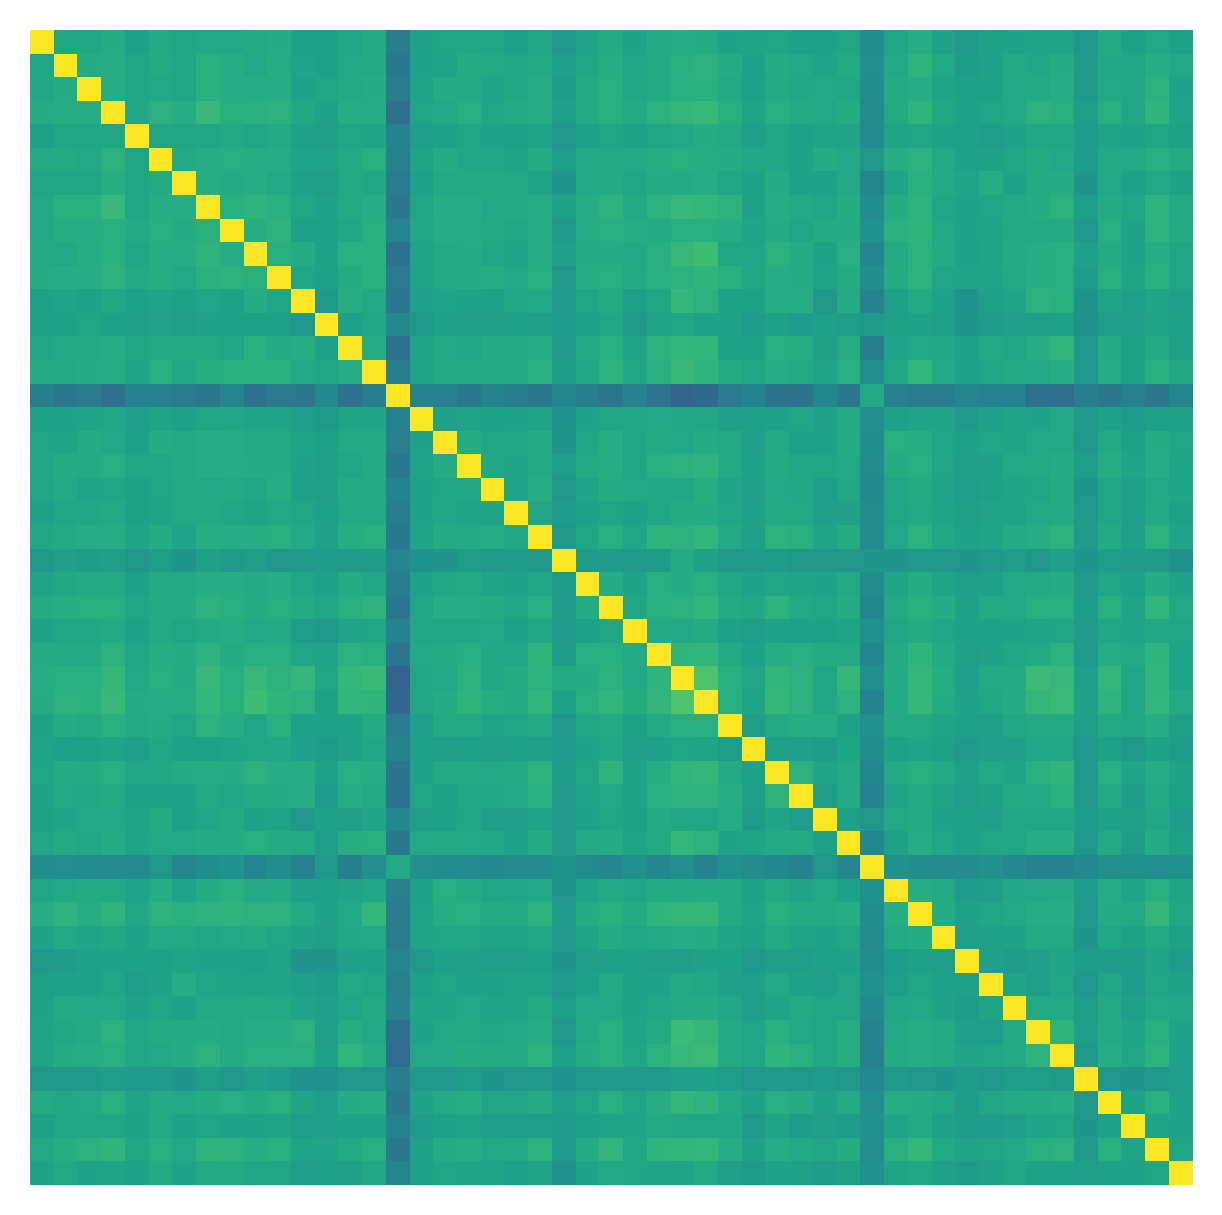

In [13]:
#construct heatmap of the GGC matrix
import seaborn as sns
from scipy.cluster import hierarchy

expression_gt = np.load("./data/filtered_expression_matrices/3/harmony3.npy")
matched_spot_expression_pred_1 = matched_spot_expression_pred.T

print(expression_gt.shape)
print(matched_spot_expression_pred_1.shape)
# (3467, 2277)
# (3467, 2277)
#plot heatmap of top 50 genes ranked by mean
def plot_heatmap(expression_gt, matched_spot_expression_pred, top_k=50):
    #take mean of expression
    mean = np.mean(expression_gt, axis=1)
    #take ind of top 100
    ind = np.argpartition(mean, -top_k)[-top_k:]

    # Compute the correlation matrix
    corr_matrix = np.corrcoef(expression_gt[ind,:])
    dendrogram = hierarchy.dendrogram(hierarchy.linkage(corr_matrix, method='ward'), no_plot=True)
    cluster_idx = dendrogram['leaves']
    
    corr_matrix = np.corrcoef(matched_spot_expression_pred[ind,:],expression_gt[ind,:])
    corr_matrix = corr_matrix[0:49, :]
    corr_matrix = corr_matrix[:, 0:49]

    # Reorder the correlation matrix and plot the heatmap
    plt.figure(dpi=300, figsize=(5,5))
    sns.heatmap(corr_matrix, cmap='viridis', xticklabels=False, yticklabels=False, cbar= False, vmin=-1, vmax=1)

plot_heatmap(expression_gt, expression_gt, top_k=50)
plot_heatmap(expression_gt, matched_spot_expression_pred_1, top_k=50)


